# ONNX, scikit-learn, persistence, deployment

**Xavier Dupré** - Senior Data Scientist at Microsoft - Computer Science Teacher at [ENSAE](http://www.ensae.fr/)

[ONNX](https://onnx.ai/) is a serialization format for machine learning models, [github/xadupre](https://github.com/xadupre), [github/sdpython](https://github.com/sdpython).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(last_level=3)

In [2]:
from pyquickhelper.helpgen import NbImage

In [3]:
%matplotlib inline

## Persistence and predictions

### Persistence with pickle

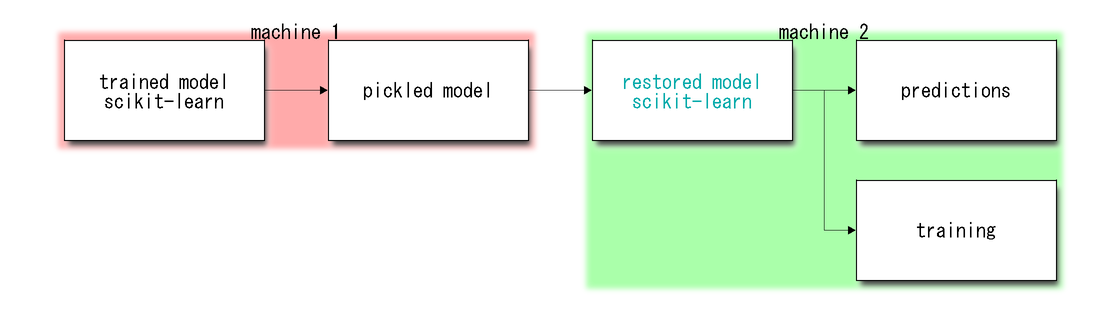

In [4]:
from pyensae.graphhelper import draw_diagram
draw_diagram("""blockdiag { default_fontsize = 20; node_width = 200; node_height = 100;
    model[label="trained model\\nscikit-learn"]; pkl[label="pickled model"];
    rest[label="restored model\\nscikit-learn", textcolor="#00AAAA"];
    pkl -> rest; pred[label="predictions"]; train[label="training"];
    group { label = "machine 1"; color = "#FFAAAA"; model -> pkl; pkl; }
    group { label = "machine 2"; color = "#AAFFAA"; rest -> pred; rest -> train; } }""")

### Main issues

* Unpickle is unstable
* Predictions are not fast (scikit-learn is optimized for batch prediction)

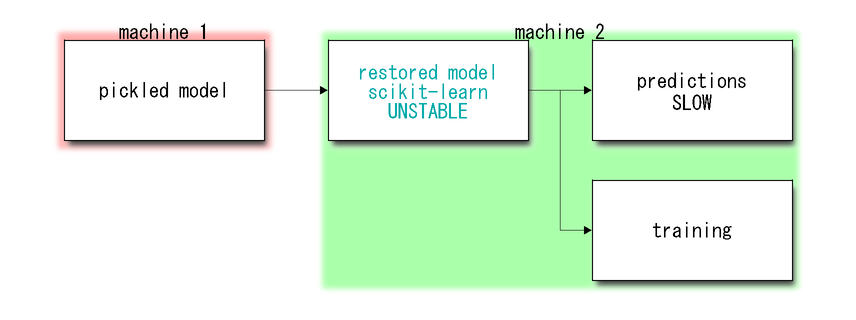

In [5]:
draw_diagram("""blockdiag { default_fontsize = 20; node_width = 200; node_height = 100;
    pkl[label="pickled model"]; rest[label="restored model\\nscikit-learn\\nUNSTABLE", textcolor="#00AAAA"];
    pkl -> rest; pred[label="predictions\\nSLOW"]; train[label="training"];
    group { label = "machine 1"; color = "#FFAAAA"; pkl; } 
    group { label = "machine 2"; color = "#AAFFAA"; rest -> pred; rest -> train; } }""")

### Iris dataset

In [6]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from pyquickhelper.pycode.profiling import profile

data = load_iris()
X, y = data.data, data.target

### Example with logistic regression

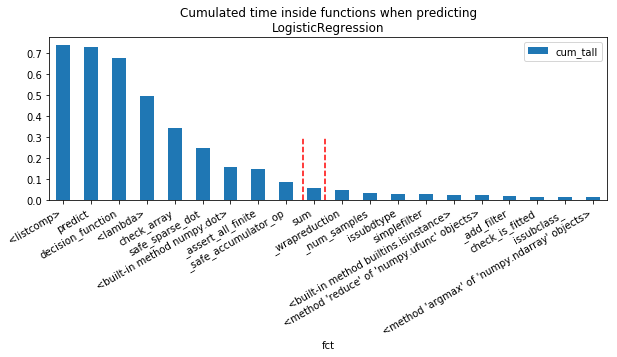

In [7]:
clr = LogisticRegression(multi_class="auto", solver="liblinear").fit(X, y)
pr, df = profile(lambda: [clr.predict(X) for i in range(0, 1000)], as_df=True, rootrem=[
    r"C:\xavierdupre\__home_\github_fork\scikit-learn", r"site-packages", r"c:\Python372_x64\lib"])
sdf = df[['fct', 'cum_tall']].head(n=20).set_index('fct')
ax = sdf.plot(kind='bar', figsize=(10,3), rot=30)
ax.set_title("Cumulated time inside functions when predicting\nLogisticRegression")
for la in ax.get_xticklabels(): la.set_horizontalalignment('right');
ax.plot([8.6, 8.6], [0, 0.3], 'r--'); ax.plot([9.4, 9.4], [0, 0.3], 'r--');

### Persistence with ONNX

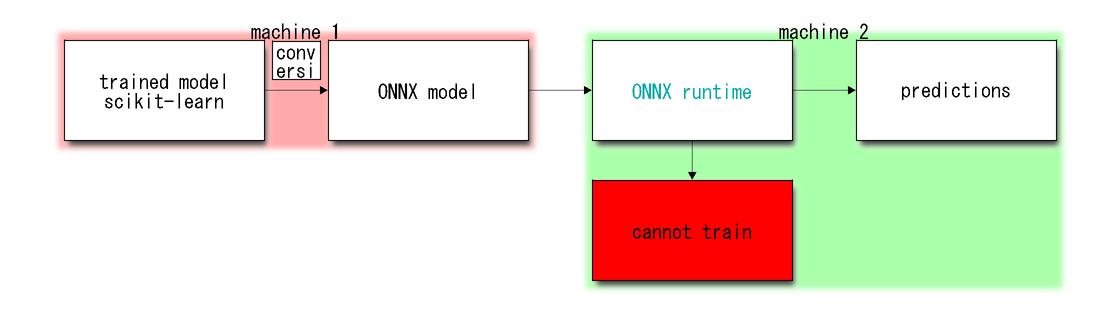

In [8]:
draw_diagram("""blockdiag { default_fontsize = 20; node_width = 200; node_height = 100;
    model[label="trained model\\nscikit-learn"]; onnx[label="ONNX model"];
    rest[label="ONNX runtime", textcolor="#00AAAA"];
    onnx -> rest; pred[label="predictions"]; notrain[label="cannot train", color="#FF0000"];
    group { label = "machine 1"; color = "#FFAAAA"; model -> onnx[label="conversion"]; onnx; }
    group { label = "machine 2"; color = "#AAFFAA"; rest ; pred;  
            rest -> pred; rest -> notrain[folded]; } }""")

### Three components for ONNX

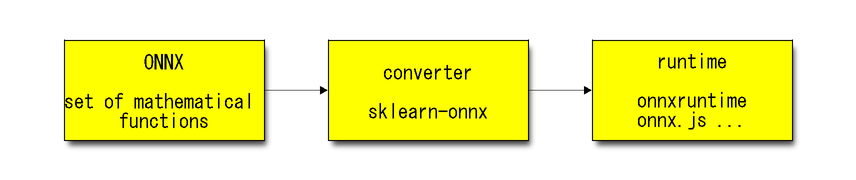

In [9]:
draw_diagram("""blockdiag { default_fontsize = 20; node_width = 200; node_height = 100;
    onnx[label="ONNX\\n\\nset of mathematical functions", color="#FFFF00"];
    conv[label="converter\\n\\nsklearn-onnx", color="#FFFF00"];
    run[label="runtime\\n\\nonnxruntime\\nonnx.js\\n...", color="#FFFF00"];
    onnx -> conv -> run ; }""")

## ONNX specifications

[ONNX](https://onnx.ai/) = Set of mathametical operations assembled into a graph. It is stable by definition.

### Matrix operations

In [10]:
beta = (X.T @ X) @ X.T @ y
beta

array([9136840.475, 4607463.549, 6276649.927, 2058848.274])

In [11]:
from skl2onnx.algebra.onnx_ops import OnnxTranspose, OnnxMatMul
import numpy as np

X32 = X.astype(np.float32)
y32 = y.astype(np.float32)

lin_reg = OnnxMatMul( 
            OnnxMatMul( 
                OnnxTranspose('input', perm=[1, 0]), 
                              X32), 
                y32)

inputs = {'input': X[:1].astype(np.float32)}
model_onnx = lin_reg.to_onnx(inputs)

print("\n".join(str(model_onnx).split('\n')[:10]) + "\n...")

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.4.9999"
domain: "ai.onnx"
model_version: 0
graph {
  node {
    input: "input"
    output: "O02"
    name: "Transpose"
...


In [12]:
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
from jyquickhelper import RenderJsDot

pydot_graph = GetPydotGraph(
    model_onnx.graph, name=model_onnx.graph.name, rankdir="TB",
    node_producer=GetOpNodeProducer("docstring", color="yellow",
                                    fillcolor="yellow", style="filled"))
dot = pydot_graph.to_string()
RenderJsDot(dot, width="20%")

### Case of a simple linear regression: dedicated operator

In [13]:
from skl2onnx.algebra.onnx_ops import OnnxLinearRegressor
doc = OnnxLinearRegressor.__doc__

In [14]:
from jupytalk.talk_examples.onnx_helper import docstring2html
docstring2html(doc.split("number of targets.")[-1])

In [18]:
from onnxconverter_common.data_types import FloatTensorType

lin_reg = OnnxLinearRegressor('input', coefficients=beta)

inputs = {'input': X[:1].astype(np.float32)}
model_onnx = lin_reg.to_onnx(inputs, outputs=[('Yp', FloatTensorType((1, 1)))])

print("\n".join(str(model_onnx).split('\n')[:12]) + "\n...")

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.4.9999"
domain: "ai.onnx"
model_version: 0
graph {
  node {
    input: "input"
    output: "O0"
    name: "LinearRegressor"
    op_type: "LinearRegressor"
    attribute {
...


In [19]:
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
from jyquickhelper import RenderJsDot

pydot_graph = GetPydotGraph(
    model_onnx.graph, name=model_onnx.graph.name, rankdir="TB",
    node_producer=GetOpNodeProducer("docstring", color="yellow",
                                    fillcolor="yellow", style="filled"))
dot = pydot_graph.to_string()
RenderJsDot(dot, width="40%")

## Conversion to ONNX

Describe the prediction function of a machine learned model with [Onnx Operators](https://github.com/onnx/onnx/blob/master/docs/Operators.md).

### scikit-learn to ONNX: sklearn-onnx

In [20]:
clr = LogisticRegression(multi_class="auto", solver="liblinear").fit(X, y)
clr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
from logging import getLogger
logger = getLogger('skl2onnx')
logger.disabled = True

In [22]:
from skl2onnx import to_onnx

model_onnx = to_onnx(clr, X.astype(np.float32))

print("\n".join(str(model_onnx).split('\n')[:10]) + "\n...")

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.4.9999"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    output: "label"
...


### Visualization as a graph

In [23]:
pydot_graph = GetPydotGraph(
    model_onnx.graph, name=model_onnx.graph.name, rankdir="LR",
    node_producer=GetOpNodeProducer("docstring", color="yellow",
                                    fillcolor="yellow", style="filled"))
dot = pydot_graph.to_string()
RenderJsDot(dot, width="100%")

### Conversion of a pipeline

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pipe = Pipeline([('pca', PCA()),
                 ('lr', LogisticRegression(multi_class="auto"))])
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [25]:
model_onnx = to_onnx(pipe, X.astype(np.float32))

In [26]:
pydot_graph = GetPydotGraph(
    model_onnx.graph, name=model_onnx.graph.name, rankdir="LR",
    node_producer=GetOpNodeProducer("docstring", color="yellow",
                                    fillcolor="yellow", style="filled"))
dot = pydot_graph.to_string()
RenderJsDot(dot, width="100%")

## Runtime

Compute predictions of a machine learned models based on its [ONNX](https://onnx.ai/) definition.

### onnxruntime

There are [multiple runtimes](https://onnx.ai/supported-tools). For CPU, GPU, ARM, [onnxruntime](https://github.com/microsoft/onnxruntime) is one option.

In [27]:
from onnxruntime import InferenceSession
sess = InferenceSession(model_onnx.SerializeToString())
label, proba = sess.run(None, {'X': X32})
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [28]:
proba[:3]

[{0: 0.5083701610565186, 1: 0.4916183650493622, 2: 1.1521970918693114e-05},
 {0: 0.5078468918800354, 1: 0.4921368956565857, 2: 1.624050310056191e-05},
 {0: 0.509240448474884, 1: 0.4907483756542206, 2: 1.1176328371220734e-05}]

In [29]:
import pandas
pandas.DataFrame(proba).head()

,0,1,2
0,0.508370,0.491618,0.000012
1,0.507847,0.492137,0.000016
2,0.509240,0.490748,0.000011
3,0.509723,0.490256,0.000021
4,0.509141,0.490848,0.000011


### ONNX.js

[API ONNX.js](https://github.com/microsoft/onnxjs/blob/master/docs/api.md)

In [30]:
with open("iris-model.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

In [31]:
model_js = "var myarr = new Uint8Array([%s]);" % ",".join(map(lambda x: str(x), model_onnx.SerializeToString()))
model_js[:200] + "..."

'var myarr = new Uint8Array([8,5,18,8,115,107,108,50,111,110,110,120,26,8,49,46,52,46,57,57,57,57,34,7,97,105,46,111,110,110,120,40,0,50,0,58,185,6,10,33,10,1,88,10,4,109,101,97,110,18,10,115,117,98,95...'

In [41]:
script = """
%s
var myOnnxSession = new onnx.InferenceSession({ backendHint: 'webgl' });
var inferenceInputs = [
    new onnx.Tensor(new Float32Array([5.1, 3.5, 1.4, 0.2]), "float32", [1, 4])
];

myOnnxSession.loadModel("my-model.onnx").then(() => {
session.run(inferenceInputs).then(output => {
  const outputTensor = output.values().next().value;
  document.getElementById("idpred").innerHTML = "<p>" + String(outputTensor) + "</p>"
});
});

document.getElementById("__ID__").innerHTML = "<p>...</p>"
""" % model_js

In [42]:
from jyquickhelper import RenderJS
jr = RenderJS(script, libs = [dict(path="https://cdn.jsdelivr.net/npm/onnxjs/dist/onnx.min.js",
                                   name="onnx", exports="onnx")])
jr

## Appendix

### Same with RandomForest

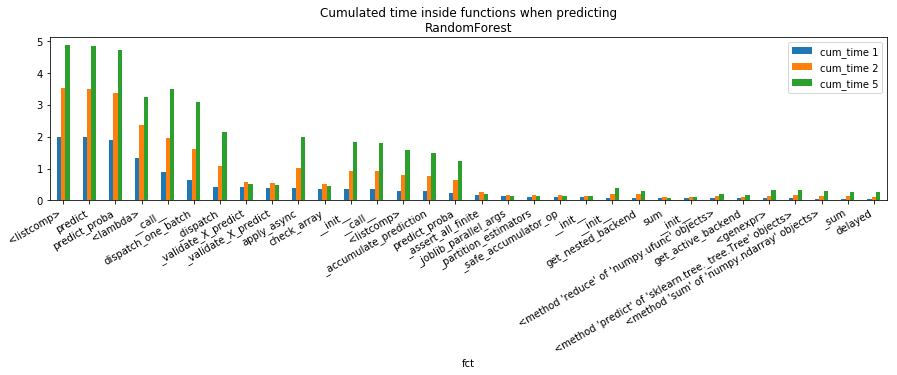

In [43]:
from sklearn.ensemble import RandomForestClassifier
sdf = None
for n in [1, 2, 5]:
    clr = RandomForestClassifier(n_estimators=n).fit(X, y)
    pr, df = profile(lambda: [clr.predict(X) for i in range(0, 1000)], as_df=True, rootrem=[
        r"C:\xavierdupre\__home_\github_fork\scikit-learn", r"site-packages", r"c:\Python372_x64\lib"])
    df = df[['fct', 'file', 'cum_tall']].head(n=35)
    df.columns = ['fct', 'file', "cum_time %d" % n]
    df = df.set_index(['fct', 'file'])
    sdf = df if sdf is None else sdf.merge(df, left_index=True, right_index=True)
sdf = sdf.sort_values("cum_time 1", ascending=False)
sdf = sdf.reset_index(drop=False).drop("file", axis=1).set_index('fct')
ax = sdf.plot(kind='bar', figsize=(15, 3), rot=30)
ax.set_title("Cumulated time inside functions when predicting\nRandomForest")
for la in ax.get_xticklabels(): la.set_horizontalalignment('right');

### Open source tools in this talk

In [44]:
import onnx, skl2onnx, sklearn, torch, onnxruntime
mods = [onnx, skl2onnx, onnxruntime, sklearn, torch]
for m in mods:
    print(m.__name__, m.__version__)

onnx 1.5.0
skl2onnx 1.4.9999
onnxruntime 0.4.0
sklearn 0.22.dev0
torch 1.1.0
